In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt

plt.style.use('bmh')

In [2]:
births = pd.DataFrame(dict(
    first = [
         1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,
         0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,
         0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,
         1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1],
    second = [
         0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
         1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,
         1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,
         0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,1,1,0,0,0,0],
))

In [3]:
n_births = births['first'].count() + births['second'].count()
n_boys =  births['first'].sum() + births['second'].sum()

first_births = births['first'].count()
first_boys = births['first'].sum()

births_after_girl = births[births['first'] == 0]['second'].count()
boys_after_girl = births[births['first'] == 0]['second'].sum()

### 3H1. 

Using grid approximation, compute the posterior distribution for the probability of a birth
being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior
probability?


In [4]:
with pm.Model() as model:
    # uninformed prior for the gender
    p = pm.Uniform('p', lower=0, upper=1)

    # both first- and second born are modeled with the same p
    boys = pm.Binomial(
        'boys',
        n=[first_births, n_births - first_births],
        p=[p, p],
        observed=[first_boys, n_boys - first_boys],
    )

    start = pm.find_MAP()

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -7.0748, ||grad|| = 11: 100%|██████████| 6/6 [00:00<00:00, 1207.63it/s]


In [5]:
np.asscalar(start['p'])

0.5549999989296014

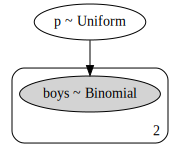

In [6]:
pm.model_to_graphviz(model)

### 3H2

Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior
density intervals.

In [7]:
with model:
    trace = pm.sample(2500, cores=4, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:06<00:00, 2040.86draws/s]


In [8]:
p_sample = pm.trace_to_dataframe(trace)['p']

In [9]:
pd.DataFrame(
    [[interval] + list(pm.hpd(p_sample, alpha=1-interval))
     for interval in (.50, .89, .97)],
    columns=['interval', 'lower', 'upper']
)    

,interval,lower,upper
0,0.50,0.528211,0.575169
1,0.89,0.500578,0.610342
2,0.97,0.476847,0.628347


### 3H3

Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to visualize the simulations, but the dens command (part of the rethinking package) is probably the easiest way in this case. Does it look like the model fits the data well? That is, does the distribution of predictions include the actual observation as a central, likely outcome?

In [10]:
with model:
    ppc = pm.sample_posterior_predictive(trace, vars=[boys], samples=10000)

100%|██████████| 10000/10000 [00:08<00:00, 1246.89it/s]


In [11]:
boys_ppc = pd.DataFrame(ppc['boys'], columns=['first', 'second'])
print(boys_ppc.shape)
boys_ppc.sample(5)

(10000, 2)


,first,second
5857,61,70
8734,49,45
4734,52,55
4473,53,47
3538,47,52


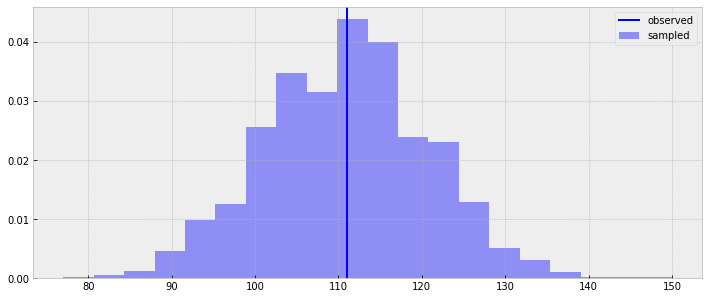

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(boys_ppc['first'] + boys_ppc['second'],
        bins=20, density=True, alpha=.4, color='b', label='sampled')
ax.axvline(x=n_boys, color='b', label='observed')
ax.legend()
None

### 3H4

Now compare 10,000 counts of boys from 100 simulated first borns only to the number of boys
in the first births, birth1. How does the model look in this light?

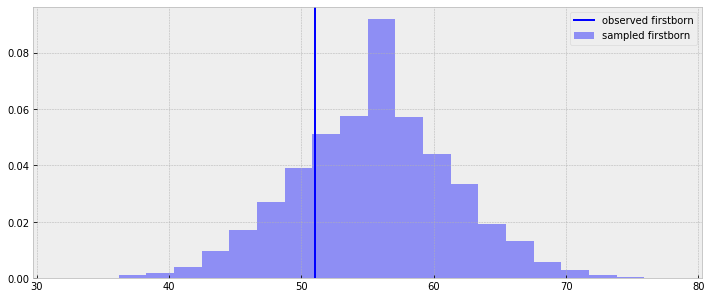

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.hist(boys_ppc['first'], bins=22, density=True, alpha=.4, color='b', label='sampled firstborn')
ax.axvline(x=first_boys, color='b', label='observed firstborn')
ax.legend()
None

### 3H5

The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns.

Compare 10,000 simulated counts of boys to only those second births that followed girls.
To do this correctly, you need to count the number of first borns who were girls and simulate that many births, 10,000 times. Compare the counts of boys in your simulations to the actual observed count of boys following girls. How does the model look in this light? Any guesses what is going on in these data?


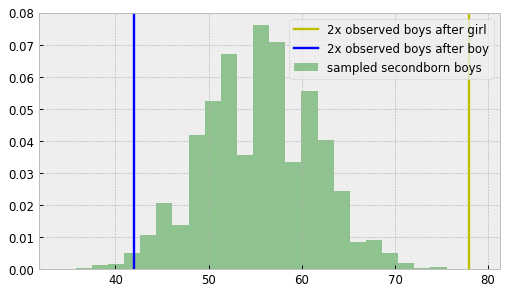

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4), dpi=85)
ax.hist(boys_ppc['second'], bins=26, density=True, alpha=.4, color='g', label='sampled secondborn boys')
ax.axvline(x=2*boys_after_girl, color='y', label='2x observed boys after girl')
ax.axvline(x=2*(n_boys - boys_after_girl - first_boys), color='b', label='2x observed boys after boy')
ax.legend()
None

Model the second birth **separately, conditioned** on the first gender

In [15]:
with pm.Model() as first_born_cond_model_:
    p1 = pm.Uniform('p1', lower=0, upper=1)

    boys1 = pm.Binomial('boys1', p=p1, n=first_births,
                        observed=first_boys)

    # two uninformed priors for second born
    p2_b = pm.Uniform('p2_b', lower=0, upper=1)
    p2_g = pm.Uniform('p2_g', lower=0, upper=1)

    # use second _b, _g for inference
    boys2_b = pm.Binomial('boys2_b', p=p2_b, n=(n_births - first_births - births_after_girl),
                          observed=(n_boys - first_boys - boys_after_girl))
    boys2_g = pm.Binomial('boys2_g', p=p2_g, n=births_after_girl,
                          observed=boys_after_girl)

    trace = pm.sample(2500, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2_g, p2_b, p1]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:09<00:00, 1497.11draws/s]


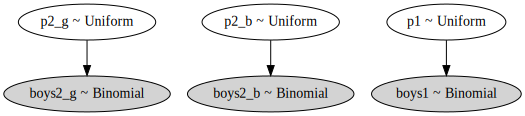

In [16]:
pm.model_to_graphviz(first_born_cond_model_)

In [17]:
trace_df = pm.trace_to_dataframe(trace)
trace_df.describe()

,p1,p2_b,p2_g
count,10000.000000,10000.000000,10000.000000
mean,0.509691,0.415022,0.784232
std,0.049875,0.067710,0.056247
min,0.320956,0.189913,0.518440
25%,0.475805,0.367723,0.748726
50%,0.510165,0.413747,0.787568
75%,0.543314,0.459941,0.823522
max,0.693354,0.677524,0.951098


In [18]:
with first_born_cond_model_:
    ppc = pm.sample_posterior_predictive(trace, samples=10000)

100%|██████████| 10000/10000 [00:13<00:00, 735.21it/s]


In [19]:
boys_ppc = pd.DataFrame(ppc)
boys_ppc.sample(5)

,boys1,boys2_b,boys2_g
9170,49,24,38
2003,49,24,42
6024,52,22,37
6395,54,24,38
896,56,21,43


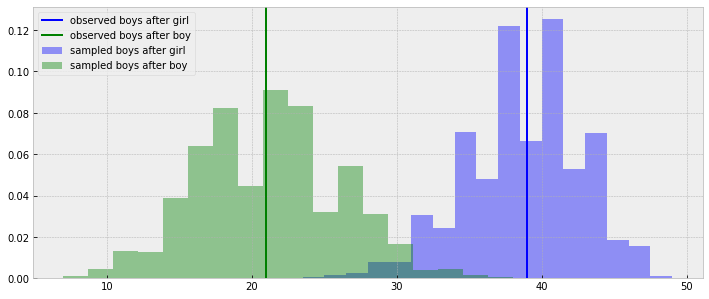

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.axvline(x=boys_after_girl, color='b', label='observed boys after girl')
ax.hist(boys_ppc['boys2_g'],
        bins=18, density=True, alpha=.4, color='b', label='sampled boys after girl')
ax.axvline(x=(n_boys - first_boys - boys_after_girl), color='g', label='observed boys after boy')
ax.hist(boys_ppc['boys2_b'],
        bins=18, density=True, alpha=.4, color='g', label='sampled boys after boy')
ax.legend()
None

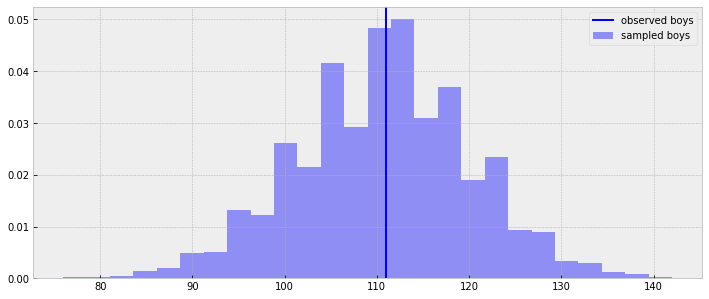

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.axvline(x=n_boys, color='b', label='observed boys')
ax.hist(boys_ppc.apply(np.sum, axis=1),
        bins=26, density=True, alpha=.4, color='b',label='sampled boys')
ax.legend()
None